## Import Packages

In [1]:
import os
import pandas as pd
import numpy as np
import random
import pickle
import datetime
import seaborn as sns
import matplotlib.pyplot as plt

## Read Training Data

### Training Dataset is the same as the one which the model is trained on

In [2]:
#Bring in data used to train pickled model that is loaded in later
df = pd.read_csv('/mnt/code/Test&TrainData/ChurnTrainingDataPP.csv')
df.drop('predictionProbability', axis =1,inplace = True)
print(f" The shape of training dataset is {df.shape}")
print("""* \n* \n*""")
df.head()

 The shape of training dataset is (7939, 7)
* 
* 
*


,custid,dropperc,mins,consecmonths,income,age,churn_Y
0,844336,0.016364,550,28,89.2,45,0
1,146041,0.018349,545,33,54.2,43,0
2,847745,0.018519,378,41,55.3,41,0
3,285565,0.014493,552,32,66.8,31,0
4,754611,0.012132,577,4,87.2,43,0


## Synthesizing Data ("df_inf")

In [3]:
#append data to istelf to double volume
df2 = df.append(df)

#Reset custid field so that there are no repeats
df2['custid'] = np.random.choice(range(df.custid.min(), df.custid.max()),df2.shape[0], replace=False)

##For each input feature adjust data and round/cast as necessary
#dropperc - 50%-150%
droppJitter = df2.dropperc.apply(lambda x : x*(random.randrange(50,150))/100)
#mins - 70%-130%
minsJitter = df2.mins.apply(lambda x : x*(random.randrange(70,130)/100)).round(0).astype(int)
#consecMonths - 80%-120%
consecMonthsJitter = df2.consecmonths.apply(lambda x : x*(random.randrange(80,120)/100)).round(0).astype(int)
#Income - 40%-160%
incomeJitter = df2.income.apply(lambda x : x*(random.randrange(40,160)/100)).round(1)
#age - 90%-110%
ageJitter = df2.age.apply(lambda x : x*(random.randrange(90,110)/100)).round(0).astype(int)

#Take all the new 'jittered' variables and write to a new df
#Keep original custid and churn_Y fields
df3 = pd.DataFrame({'custid': df2.custid,
       'dropperc': droppJitter, 
       'mins': minsJitter,
       'consecmonths': consecMonthsJitter,
       'income': incomeJitter,
       'age': ageJitter,
       'churn_Y': df2.churn_Y
                   })

#Understand correlations between new jittered data and original
#Should see larger data drift for lower correlations
concatset = pd.concat([df2,df3], axis =1)
concatset.columns=(list(df2.columns)+list('Jittered_'+df3.columns))
print('Correlations between original and altered vars -')
for i,k in enumerate(df2.columns):
    print('{}: {}'.format(k, concatset.corr()[k]['Jittered_'+k].round(4)))

Correlations between original and altered vars -
custid: 1.0
dropperc: 0.7317
mins: 0.7414
consecmonths: 0.9295
income: 0.6178
age: 0.9692
churn_Y: 1.0


In [4]:
#Grab between 100 and 500 random rows from jittered data
df_inf = df3.sample(n = random.randint(100,500))
print(df_inf.shape[0], "records selected for sample")
df_inf.head()

print(f" The shape of df_inf for prediction data is {df_inf.shape}")
print("""* \n* \n*""")
df_inf.head()

397 records selected for sample
 The shape of df_inf aka jittered training dataset is (397, 7)
* 
* 
*


,custid,dropperc,mins,consecmonths,income,age,churn_Y
927,265574,0.020926,535,29,30.1,41,0
2408,469912,0.027179,459,22,73.2,54,0
4141,44508,0.012835,459,27,58.8,49,0
4840,168393,0.043139,553,19,84.6,48,0
1287,685472,0.017965,655,23,45.0,27,0


### Synthesize data features ("X")

In [ ]:
#Save input features
X = df_inf.loc[:, 'dropperc':'age']
print(f"shape of X is {X.shape}")
X.head()

## Load Model

In [5]:
#Load in trained model object    
loaded_model = pickle.load(open('/mnt/code/models/ChurnBinaryClassifier.pkl', 'rb'))

shape of X is (397, 5)


/opt/conda/lib/python3.8/site-packages/sklearn/base.py:329: UserWarning: Trying to unpickle estimator DecisionTreeClassifier from version 0.22.2 when using version 1.0.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/opt/conda/lib/python3.8/site-packages/sklearn/base.py:329: UserWarning: Trying to unpickle estimator AdaBoostClassifier from version 0.22.2 when using version 1.0.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
  warnings.warn(


,dropperc,mins,consecmonths,income,age
927,0.020926,535,29,30.1,41
2408,0.027179,459,22,73.2,54
4141,0.012835,459,27,58.8,49
4840,0.043139,553,19,84.6,48
1287,0.017965,655,23,45.0,27


### a. "predictions" values 
#### Array of binary values which is from loaded model using features of Synthesized data (X) **** 0 or 1

In [28]:
#Get model predictions for the sample of input features defined above
predictions = loaded_model.predict(X)
print(f"lenght of prediction is {len(predictions)}")
predictions[:5]

lenght of prediction is 397


/opt/conda/lib/python3.8/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but AdaBoostClassifier was fitted without feature names
  warnings.warn(


array([0, 0, 0, 0, 0])

### b. "probas" Prediction probability range using features of Synthesized data (df_inf) **** between [0.xx, 0.xx]

In [13]:
#Get model prediction probabilities for the sample of input features defined above
#probas = tuple(loaded_model.predict_proba(X).tolist()) # converting from array to list to be compatible for dataframe probability range
probas = loaded_model.predict_proba(X).tolist() # converting from array to list to be compatible for dataframe probability range

print(f"lenght of probas is {len(probas)}") # probas is a list of ranges
probas[:4]

lenght of probas is 397


/opt/conda/lib/python3.8/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but AdaBoostClassifier was fitted without feature names
  warnings.warn(


[[0.5537376156742894, 0.4462623843257107],
 [0.5626819529235282, 0.43731804707647187],
 [0.7032368254094384, 0.2967631745905616],
 [0.5089288121401815, 0.4910711878598185]]

## ***"churn_groundTruth"*** 
### Synthesized data feature selection only index and output which are custid and churn_Y renamed to y_gt)

In [29]:
churn_groundTruth = pd.DataFrame(df_inf[['custid','churn_Y']]).rename(columns = {'churn_Y': 'y_gt'})
churn_groundTruth.head()

,custid,y_gt
927,265574,0
2408,469912,0
4141,44508,0
4840,168393,0
1287,685472,0


## ***"churn_inputs_and_preds"***
#### Synthesized data df_inf - output(or churn_Y) + predictions (binaries) + probas (probability range)

In [35]:
#Create data set with predictions and pred probabilities
preds_df = pd.DataFrame(data=predictions, columns=['churn_Y'], index=churn_groundTruth.index)
#preds_df.head()

In [36]:
preds_df['predictionProbability']= probas
#preds_df.head()

In [37]:
#df_inf.head()

In [38]:
#join prediction and prob data with input features dropping churn_Y
churn_inputs_and_preds = df_inf.drop('churn_Y', axis =1)\
.join(preds_df, how = 'inner').drop_duplicates(subset = 'custid')

#### Adding Gender feature to the churn_inputs_and_preds

In [39]:
#Create 'protected class' feature to monitor for disparity in target distribution
churn_inputs_and_preds['Gender']=np.random.randint(0,3, churn_inputs_and_preds.shape[0])
mymap = {0:'M',1: 'F', 2: 'NB'}
churn_inputs_and_preds['Gender'] = churn_inputs_and_preds['Gender'].apply(lambda x: mymap.get(x))
churn_inputs_and_preds.head()

,custid,dropperc,mins,consecmonths,income,age,churn_Y,predictionProbability,Gender
33,837846,0.025594,451,34,65.2,32,0,"[0.518072815536917, 0.481927184463083]",F
51,515869,0.013675,509,40,35.6,35,0,"[0.70118509288953, 0.29881490711047004]",F
61,323852,0.030958,431,38,41.0,20,1,"[0.499990828816656, 0.500009171183344]",M
63,254688,0.020693,433,52,48.8,38,0,"[0.5465708614836464, 0.4534291385163536]",M
69,148676,0.014685,339,13,47.5,41,0,"[0.7593104108625176, 0.24068958913748234]",F


## Visualization (Gender vs Churn_Y (average))

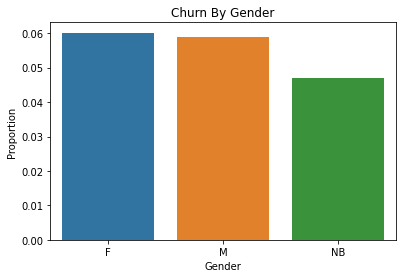

In [18]:
#Add visualization of protected class for tracking purposes
ax = sns.barplot(x = ['F', 'M', 'NB'], y = churn_inputs_and_preds.groupby('Gender').mean()['churn_Y'])

ax.set_title('Churn By Gender')
ax.set_ylabel('Proportion')
ax.set_xlabel('Gender')
fig = ax.get_figure()
fig.set_size_inches(12,4)
plt.gcf().subplots_adjust(left=0.5)

#fig.savefig('/mnt/code/Viz/protected_class_monitoring.png')

## Check Pass for Writing Data ***inputs_and_preds*** & ***groundTruth***

In [19]:
## Run two checks below to validate input and GT data is of same size and contains same custIDs

lenCheck = churn_inputs_and_preds.shape[0]==churn_groundTruth.shape[0]
print('Length Check Pass:', lenCheck)

idCheck= (churn_inputs_and_preds.custid.sort_values()==churn_groundTruth.custid.sort_values())\
.sum() ==churn_inputs_and_preds.shape[0]
print('ID Check Pass:', idCheck)

Length Check Pass: True
ID Check Pass: True


In [40]:
churn_inputs_and_preds.shape

(397, 9)

In [41]:
churn_groundTruth.shape

(397, 2)

## Writing Prediction and GT data locally to DailyData directory

In [42]:
# Write input and pred data to DailyData folder #
daily_data_path = '/mnt/code/DailyData/'
input_and_pred_path = str(daily_data_path+'inputs_and_preds_'+str(datetime.date.today())+'.csv')
ground_truth_path = str(daily_data_path+'ground_truth_'+str(datetime.date.today())+'.csv')

# saving Prediction data to csv
churn_inputs_and_preds.to_csv(input_and_pred_path, index = False)

# saving Ground Truth data to csv
churn_groundTruth.to_csv(ground_truth_path, index = False)

## Upload the Prediction data and Ground Truth to S3 bucket

In [23]:
import certs
bucket = certs.bucket

In [24]:
import upload_to_s3
#Upload input&pred data and GT data to s3 bucket 
upload_to_s3.upload(input_and_pred_path, bucket)
upload_to_s3.upload(ground_truth_path, bucket)

inputs_and_preds_2022-05-05.csv Upload Successful
ground_truth_2022-05-05.csv Upload Successful


True

# DMM Method A: Manual Prediction and GT registration

At the end of the above stage there must be at least 5 files in your Amazon S3 bucket:
1. ChurnTrainingDataPP.csv
2. inputs_and_preds_2021-09-16.csv
3. ground_truth_2021-09-16.csv
4. inputs_and_preds_xxxx-xx-xx.csv
5. ground_truth_xxxx-xx-xx.csv

### 1. Register the model using the following format

### 2. Register the Prediction data

### 3. Register the Ground Truth data *initial registration*

### 4. Register the Prediction data (calculated in this notebook)

### 5. Register the Ground Truth data (calculated in this notebook)

# DMM Method B: Prediction and GT registration using API endpoint
#### demonstrating the process for step 4 and 5

#### At this point the input-pred.csv and the ground_truth.csv are saved in S3 bucket

In [ ]:
import requests

In [ ]:
#import certs

dmm_api_key = certs.dmm_api_key

#model_id = '<dmm-model-id>'
model_id = certs.model_id


In [49]:
#Define file names for payload construction below
inputs_file_name = str('inputs_and_preds_'+str(datetime.date.today())+'.csv')
print(f" the input_file_name is: {inputs_file_name}")

ground_truth_file_name = str('ground_truth_'+str(datetime.date.today())+'.csv')
print(f" The ground_truth_file_name is: {ground_truth_file_name}")

 the input_file_name is: inputs_and_preds_2022-05-06.csv
 The ground_truth_file_name is: ground_truth_2022-05-06.csv


In [ ]:
#Define api endpoint # Adding dmm model ID
inputs_url = "https://demo.dominodatalab.com/model-monitor/v2/api/model/{}/register-dataset/prediction".format(model_id)

In [ ]:
inputs_file_name

In [ ]:
#Create inputs and prediction data payload
inputs_payload = """
{{
"datasetDetails": {{
        "name": "{0}",
        "datasetType": "file",
        "datasetConfig": {{
            "path": "{0}",
            "fileFormat": "csv"
        }},
        "datasourceName": "churn-dmm-46",
        "datasourceType": "s3"
    }}
}}
""".format(inputs_file_name)

In [ ]:
#Set up call headers  # Adding dmm_api_key
headers = {
           'X-DMM-API-KEY': dmm_api_key,
           'Content-Type': 'application/json'
          }

In [ ]:
#Make API call # importing requests
inputs_response = requests.request("PUT", inputs_url, headers=headers, data = inputs_payload)

In [ ]:
#create GT payload    
ground_truth_payload = """
{{

"datasetDetails": {{
        "name": "{0}",
        "datasetType": "file",
        "datasetConfig": {{
            "path": "{0}",
            "fileFormat": "csv"
        }},
        "datasourceName": "churn-dmm-46",
        "datasourceType": "s3"
    }}
}}
""".format(ground_truth_file_name)

In [ ]:
#Define api endpoint
ground_truth_url = "https://demo.dominodatalab.com/model-monitor/v2/api/model/{}/register-dataset/ground_truth".format(model_id)

In [ ]:
#Make api call
ground_truth_response = requests.request("PUT", ground_truth_url, headers=headers, data = ground_truth_payload)

In [ ]:
#Print response
print(ground_truth_response.text.encode('utf8'))